# Carga de Librerías

In [1]:
from numpy.random import seed
seed(2)

import tensorflow as tf
tf.random.set_seed(2) 

import sys  
sys.path.insert(0, "C:\\PdM\\utils")
from utils_models import window_size

import pandas as pd
import numpy as np

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae

from pickle import dump
from pickle import load

# Introducción
Este notebook realizará el modelo de predicción de RUL a través de un algoritmo LSTM.

# Carga de datos y creación columna RUL

Cargamos los archivos csv creados anteriormente con la telemetría y las anomálias (0 = normal, 1 = anómalo) generadas por los modelos Autoencoder LSTM.  
Puesto que cada archivo es una serie temporal desde el último fallo hasta el siguiente, podemos generar una columna decreciente en ciclos que simula los ciclos (en este caso horas) pendientes antes de que la máquina falle (-> columna RUL) que representará los valores de la variable a predecir.

In [2]:
# Definición de la misma ventana temporal que en el Autoencoder LSTM por consitencia. 
size_window = window_size()

# Carga del archivo csv con los resultados (anomalías) del Autoencoder LSTM

list_path_autoencoders = ["C:\\PdM\\datasets\\AE_working_dataset_Autoeconder\\autoencoder_M34_S1.csv",
                          "C:\\PdM\\datasets\\AE_working_dataset_Autoeconder\\autoencoder_M34_S2.csv",
                          "C:\\PdM\\datasets\\AE_working_dataset_Autoeconder\\autoencoder_M48_S1.csv",
                          "C:\\PdM\\datasets\\AE_working_dataset_Autoeconder\\autoencoder_M48_S2.csv",
                          "C:\\PdM\\datasets\\AE_working_dataset_Autoeconder\\autoencoder_M48_S3.csv",
                          "C:\\PdM\\datasets\\AE_working_dataset_Autoeconder\\autoencoder_M57_S1.csv",
                          "C:\\PdM\\datasets\\AE_working_dataset_Autoeconder\\autoencoder_M57_S2.csv"]

all_df = []
for path_ in list_path_autoencoders:
    df = pd.read_csv(path_)

    # Creación de los valores RUL (decrecientes hasta llegar a cero)
    df["RUL"] = [abs(x - df.shape[0] + 1) for x in df.index]
    df = df[size_window-1:]
    df = df.set_index("datetime")
    all_df.append(df)

In [3]:
df_M34_S1 = all_df[0]
df_M34_S2 = all_df[1]
df_M48_S1 = all_df[2]
df_M48_S2 = all_df[3]
df_M48_S3 = all_df[4]
df_M57_S1 = all_df[5]
df_M57_S2 = all_df[6]

print(f"Filas de M34_S1: {df_M34_S1.shape[0]}")
print(f"Filas de M34_S2: {df_M34_S2.shape[0]}")
print(f"Filas de M48_S1: {df_M48_S1.shape[0]}")
print(f"Filas de M48_S2: {df_M48_S2.shape[0]}")
print(f"Filas de M48_S3: {df_M48_S3.shape[0]}")
print(f"Filas de M57_S1: {df_M57_S1.shape[0]}")
print(f"Filas de M57_S2: {df_M57_S2.shape[0]}")

Filas de M34_S1: 2102
Filas de M34_S2: 4981
Filas de M48_S1: 1323
Filas de M48_S2: 2632
Filas de M48_S3: 852
Filas de M57_S1: 830
Filas de M57_S2: 6421


Observamos que los diferentes archivos tienen longitudes diferentes. Para homogeneizar los datasets y evitar predicciones fuera de rangos, realizaremos los cambios necesarios para que tengamos en todos los datasets el mismo número de filas (mínimo de los juegos disponibles).

In [4]:
len_df_model = min(df_M34_S1.shape[0],
                   df_M34_S2.shape[0], 
                   df_M48_S1.shape[0], 
                   df_M48_S2.shape[0], 
                   df_M48_S3.shape[0], 
                   df_M57_S1.shape[0], 
                   df_M57_S2.shape[0] )
print(f"El número de filas mínimo en los dataframes de estudio es {len_df_model} filas")

El número de filas mínimo en los dataframes de estudio es 830 filas


Recortamos todos los dataframes para que tengan el mismo número de filas para que el modelo se cree de forma consistente.

In [5]:
df_M34_S1 = df_M34_S1.iloc[-len_df_model:]
df_M34_S2 = df_M34_S2.iloc[-len_df_model:]
df_M48_S1 = df_M48_S1.iloc[-len_df_model:]
df_M48_S2 = df_M48_S2.iloc[-len_df_model:]
df_M48_S3 = df_M48_S3.iloc[-len_df_model:]
df_M57_S1 = df_M57_S1.iloc[-len_df_model:]
df_M57_S2 = df_M57_S2.iloc[-len_df_model:]

print(f"Filas de M34_S1: {df_M34_S1.shape[0]}")
print(f"Filas de M34_S2: {df_M34_S2.shape[0]}")
print(f"Filas de M48_S1: {df_M48_S1.shape[0]}")
print(f"Filas de M48_S2: {df_M48_S2.shape[0]}")
print(f"Filas de M48_S3: {df_M48_S3.shape[0]}")
print(f"Filas de M57_S1: {df_M57_S1.shape[0]}")
print(f"Filas de M57_S2: {df_M57_S2.shape[0]}")

Filas de M34_S1: 830
Filas de M34_S2: 830
Filas de M48_S1: 830
Filas de M48_S2: 830
Filas de M48_S3: 830
Filas de M57_S1: 830
Filas de M57_S2: 830


Antes de realizar el modelo, deberemos normalizar tanto los valores de las características como los valores RUL. 
   
Normalizamos en conjunto **solamente los valores que entrenarán el modelo**. 
   
Guardamos en disco las normalizaciones para su posterior utilización (formato pkl)

In [6]:
# Subconjuntos de entrenamiento
subconj_E1 = df_M34_S1
subconj_E2 = df_M34_S2
subconj_E3 = df_M48_S2
subconj_E4 = df_M48_S3
subconj_E5 = df_M57_S1
subconj_E6 = df_M57_S2

# Conjunto de test
subconj_T = df_M48_S1

In [7]:
# Concatenamos los subconjuntos considerados para el entrenamiento del modelo
df = pd.concat([subconj_E1, subconj_E2, subconj_E3, subconj_E4, subconj_E5, subconj_E6])

print(f"Filas de todos los dataframes: {df.shape[0]}")
df.shape[0] == subconj_E1.shape[0] + subconj_E2.shape[0]\
               + subconj_E3.shape[0] + subconj_E4.shape[0]\
               + subconj_E5.shape[0] + subconj_E6.shape[0]

Filas de todos los dataframes: 4980


True

In [8]:
# Normalizaciones de las características y de la columna a predecir.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

column_features = ['volt',
                   'rotate',
                   'pressure', 
                   'vibration']
column_label = ['RUL']


df[column_features] = scaler_features.fit_transform(df[column_features])
df[column_label] = scaler_label.fit_transform(df[column_label])

dump(scaler_features, open('C:\\PdM\\datasets\\LSTM_working_dataset_LSTM\\LSTM_scaler_features_without_anomalies.pkl', 'wb'))
dump(scaler_label, open('C:\\PdM\\datasets\\LSTM_working_dataset_LSTM\\LSTM_scaler_label_without_anomalies.pkl', 'wb'))

Mostramos el juego de datos normalizado:

In [9]:
df

volt    rotate  pressure  vibration  Anomaly_volt  \
datetime                                                                     
3/12/2015 17:00      0.692156  0.489661  0.483985   0.454483           0.0   
3/12/2015 18:00      0.332352  0.494145  0.518536   0.573437           0.0   
3/12/2015 19:00      0.484067  0.561053  0.651408   0.545552           0.0   
3/12/2015 20:00      0.397042  0.673338  0.496646   0.578461           0.0   
3/12/2015 21:00      0.303909  0.538113  0.575265   0.424152           0.0   
...                       ...       ...       ...        ...           ...   
2015-11-04 02:00:00  0.618136  0.427956  0.595623   0.314280           1.0   
2015-11-04 03:00:00  0.538762  0.200759  0.402552   0.422316           1.0   
2015-11-04 04:00:00  0.546304  0.274613  0.543442   0.651875           1.0   
2015-11-04 05:00:00  0.705502  0.608584  0.457911   0.475919           1.0   
2015-11-04 06:00:00  0.600080  0.555603  0.483139   0.301916           1.0   

                     Anomaly_rotate  Anomaly_pressure  Anomaly_vibration  \
datetime                                                                   
3/12/2015 17:00                 0.0               0.0                1.0   
3/12/2015 18:00                 0.0               0.0                0.0   
3/12/2015 19:00                 0.0               0.0                0.0   
3/12/2015 20:00                 0.0               0.0                0.0   
3/12/2015 21:00                 0.0               0.0                0.0   
...                             ...               ...                ...   
2015-11-04 02:00:00             0.0               0.0                0.0   
2015-11-04 03:00:00             0.0               0.0                0.0   
2015-11-04 04:00:00             0.0               0.0                0.0   
2015-11-04 05:00:00             0.0               0.0                0.0   
2015-11-04 06:00:00             0.0               0.0                0.0   

                          RUL  
datetime                       
3/12/2015 17:00      1.000000  
3/12/2015 18:00      0.998794  
3/12/2015 19:00      0.997587  
3/12/2015 20:00      0.996381  
3/12/2015 21:00      0.995175  
...                       ...  
2015-11-04 02:00:00  0.004825  
2015-11-04 03:00:00  0.003619  
2015-11-04 04:00:00  0.002413  
2015-11-04 05:00:00  0.001206  
2015-11-04 06:00:00  0.000000  

[4980 rows x 9 columns]

Normalizaremos el conjunto de datos **completo (entrenamiento y validación)** mediante la normalización del conjunto de entrenamiento.

In [10]:
# Concatenamos la totalidad de los datos, incluyendo lo de test
df = pd.concat([subconj_E1, subconj_E2, subconj_E3, subconj_E4, subconj_E5, subconj_E6, subconj_T])

print(f"Filas de todos los dataframes: {df.shape[0]}")
df.shape[0] == subconj_E1.shape[0] + subconj_E2.shape[0]\
               + subconj_E3.shape[0] + subconj_E4.shape[0]\
               + subconj_E5.shape[0] + subconj_E6.shape[0] + subconj_T.shape[0] 

Filas de todos los dataframes: 5810


True

In [11]:
# Normalización de características del conjunto completo, incluyendo el conjunto de validación

column_features = ['volt', 
                   'rotate', 
                   'pressure', 
                   'vibration']
column_label = ['RUL']

LSTM_scaler_features_path_file = "C:\\PdM\\datasets\\LSTM_working_dataset_LSTM\\LSTM_scaler_features_without_anomalies.pkl"
scaler_features = load(open(LSTM_scaler_features_path_file, 'rb'))

df[column_features] = scaler_features.transform(df[column_features])


LSTM_scaler_label_path_file = "C:\\PdM\\datasets\\LSTM_working_dataset_LSTM\\LSTM_scaler_label_without_anomalies.pkl"
scaler_label = load(open(LSTM_scaler_label_path_file, 'rb'))

df[column_label] = scaler_label.transform(df[column_label])
df


volt    rotate  pressure  vibration  Anomaly_volt  \
datetime                                                                 
3/12/2015 17:00  0.692156  0.489661  0.483985   0.454483           0.0   
3/12/2015 18:00  0.332352  0.494145  0.518536   0.573437           0.0   
3/12/2015 19:00  0.484067  0.561053  0.651408   0.545552           0.0   
3/12/2015 20:00  0.397042  0.673338  0.496646   0.578461           0.0   
3/12/2015 21:00  0.303909  0.538113  0.575265   0.424152           0.0   
...                   ...       ...       ...        ...           ...   
3/12/2015 2:00   0.634569  0.569274  0.151531   0.400494           1.0   
3/12/2015 3:00   1.012803  0.453360  0.464868   0.564883           1.0   
3/12/2015 4:00   0.540733  0.127335  0.685735   0.432489           1.0   
3/12/2015 5:00   0.700535  0.571437  0.741841   0.305349           1.0   
3/12/2015 6:00   0.555457  0.309815  0.940775   0.560471           1.0   

                 Anomaly_rotate  Anomaly_pressure  Anomaly_vibration       RUL  
datetime                                                                        
3/12/2015 17:00             0.0               0.0                1.0  1.000000  
3/12/2015 18:00             0.0               0.0                0.0  0.998794  
3/12/2015 19:00             0.0               0.0                0.0  0.997587  
3/12/2015 20:00             0.0               0.0                0.0  0.996381  
3/12/2015 21:00             0.0               0.0                0.0  0.995175  
...                         ...               ...                ...       ...  
3/12/2015 2:00              0.0               0.0                0.0  0.004825  
3/12/2015 3:00              0.0               0.0                0.0  0.003619  
3/12/2015 4:00              0.0               0.0                0.0  0.002413  
3/12/2015 5:00              0.0               0.0                0.0  0.001206  
3/12/2015 6:00              0.0               0.0                0.0  0.000000  

[5810 rows x 9 columns]

# Creación modelo LSTM

Configurarmos el juego de datos de tal forma que sea aceptable por el modelo LSTM.  
Para ello definimos una función que acumulará tantos valores como su ventana temporal definida.

In [12]:
def create_dataset_LSTM(df, lookback, future, column_features, column_label):
    df_feature = df[column_features]
    df_rul = df[column_label][lookback-1:]

    # Convertimos el dataframe en un numpy array
    numpy_features = df_feature.to_numpy()
    labels = df_rul.to_numpy()
    
    # Creación de listas vacías auxiliares
    features_set = [] 
   
    for i in range(lookback, df.shape[0] - future + 1):
        features_set.append(numpy_features[i - lookback:i]) 

    # Redimensionamiento numpy arrays
    features = np.array(features_set)
    features = np.reshape(features, (features.shape[0], features.shape[1], len(column_features) ))

    return features, labels

Una vez hecha la normalización en conjunto, deberemos dividir de nuevo los datos en sus respectivas series para crear las series temporales de forma independiente  
 **para evitar mezclar datos de máquinas y series diferentes.**

In [13]:
# Definición de los índices para separar cada dataset del dataframe del conjunto de entrenamiento y test
indice_final_subconj_E1 = len_df_model
indice_final_subconj_E2 = indice_final_subconj_E1 + len_df_model
indice_final_subconj_E3 = indice_final_subconj_E2 + len_df_model
indice_final_subconj_E4 = indice_final_subconj_E3 + len_df_model
indice_final_subconj_E5 = indice_final_subconj_E4 + len_df_model
indice_final_subconj_E6 = indice_final_subconj_E5 + len_df_model
indice_final_subconj_T =  indice_final_subconj_E6 + len_df_model

In [14]:
# Generamos los dataframes por separado y normalizados
subconj_E1_norm = df[0:indice_final_subconj_E1]
subconj_E2_norm = df[indice_final_subconj_E1:indice_final_subconj_E2]
subconj_E3_norm = df[indice_final_subconj_E2:indice_final_subconj_E3]
subconj_E4_norm = df[indice_final_subconj_E3:indice_final_subconj_E4]
subconj_E5_norm = df[indice_final_subconj_E4:indice_final_subconj_E5]
subconj_E6_norm = df[indice_final_subconj_E5:indice_final_subconj_E6]
subconj_T_norm  = df[indice_final_subconj_E6:indice_final_subconj_T]

print(subconj_E1_norm.shape[0] == subconj_E2_norm.shape[0]\
                               == subconj_E3_norm.shape[0]\
                               == subconj_E4_norm.shape[0]\
                               == subconj_E5_norm.shape[0]\
                               == subconj_E6_norm.shape[0]\
                               == subconj_T_norm.shape[0])

print(f"El número de filas de cada uno de los dataframes es: {subconj_E1_norm.shape[0]}")

True
El número de filas de cada uno de los dataframes es: 830


Definimos los conjuntos de entrenamiento tanto de las características como de las etiquetas mediante la función anterior.

Para subconj_E1:

In [15]:
df = subconj_E1_norm
data_X_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[0]
print(f"Dimensiones del subconjunto (características):\
     {data_X_train_LSTM.shape[0]} filas, {data_X_train_LSTM.shape[2]} columnas, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

data_Y_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[1]
print(f"Dimensiones del subconjunto (etiquetas):\
     {data_X_train_LSTM.shape[0]} filas y {data_Y_train_LSTM.shape[1]} columna, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

subconj_X1  = data_X_train_LSTM
subconj_Y1  = data_Y_train_LSTM

Dimensiones del subconjunto (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del subconjunto (etiquetas):     771 filas y 1 columna, ventana temporal de 60 ciclos


Para subconj_E2:

In [16]:
df = subconj_E2_norm
data_X_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[0]
print(f"Dimensiones del subconjunto (características):\
     {data_X_train_LSTM.shape[0]} filas, {data_X_train_LSTM.shape[2]} columnas, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

data_Y_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[1]
print(f"Dimensiones del subconjunto (etiquetas):\
     {data_X_train_LSTM.shape[0]} filas y {data_Y_train_LSTM.shape[1]} columna, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

subconj_X2  = data_X_train_LSTM
subconj_Y2  = data_Y_train_LSTM

Dimensiones del subconjunto (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del subconjunto (etiquetas):     771 filas y 1 columna, ventana temporal de 60 ciclos


Para subconj_E3:

In [17]:
df = subconj_E3_norm
data_X_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[0]
print(f"Dimensiones del subconjunto (características):\
     {data_X_train_LSTM.shape[0]} filas, {data_X_train_LSTM.shape[2]} columnas, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

data_Y_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[1]
print(f"Dimensiones del subconjunto (etiquetas):\
     {data_X_train_LSTM.shape[0]} filas y {data_Y_train_LSTM.shape[1]} columna, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

subconj_X3  = data_X_train_LSTM
subconj_Y3  = data_Y_train_LSTM

Dimensiones del subconjunto (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del subconjunto (etiquetas):     771 filas y 1 columna, ventana temporal de 60 ciclos


Para subconj_E4:

In [18]:
df = subconj_E4_norm
data_X_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[0]
print(f"Dimensiones del subconjunto (características):\
     {data_X_train_LSTM.shape[0]} filas, {data_X_train_LSTM.shape[2]} columnas, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

data_Y_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[1]
print(f"Dimensiones del subconjunto (etiquetas):\
     {data_X_train_LSTM.shape[0]} filas y {data_Y_train_LSTM.shape[1]} columna, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

subconj_X4  = data_X_train_LSTM
subconj_Y4  = data_Y_train_LSTM

Dimensiones del subconjunto (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del subconjunto (etiquetas):     771 filas y 1 columna, ventana temporal de 60 ciclos


Para subconj_E5:

In [19]:
df = subconj_E5_norm
data_X_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[0]
print(f"Dimensiones del subconjunto (características):\
     {data_X_train_LSTM.shape[0]} filas, {data_X_train_LSTM.shape[2]} columnas, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

data_Y_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[1]
print(f"Dimensiones del subconjunto (etiquetas):\
     {data_X_train_LSTM.shape[0]} filas y {data_Y_train_LSTM.shape[1]} columna, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

subconj_X5  = data_X_train_LSTM
subconj_Y5  = data_Y_train_LSTM

Dimensiones del subconjunto (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del subconjunto (etiquetas):     771 filas y 1 columna, ventana temporal de 60 ciclos


Para subconj_E6:

In [20]:
df = subconj_E6_norm
data_X_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[0]
print(f"Dimensiones del subconjunto (características):\
     {data_X_train_LSTM.shape[0]} filas, {data_X_train_LSTM.shape[2]} columnas, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

data_Y_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[1]
print(f"Dimensiones del subconjunto (etiquetas):\
     {data_X_train_LSTM.shape[0]} filas y {data_Y_train_LSTM.shape[1]} columna, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

subconj_X6  = data_X_train_LSTM
subconj_Y6  = data_Y_train_LSTM

Dimensiones del subconjunto (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del subconjunto (etiquetas):     771 filas y 1 columna, ventana temporal de 60 ciclos


Para subconj_T:

In [21]:
df = subconj_T_norm
data_X_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[0]
print(f"Dimensiones del subconjunto (características):\
     {data_X_train_LSTM.shape[0]} filas, {data_X_train_LSTM.shape[2]} columnas, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

data_Y_train_LSTM = create_dataset_LSTM(df, size_window, 0, column_features, column_label)[1]
print(f"Dimensiones del subconjunto (etiquetas):\
     {data_X_train_LSTM.shape[0]} filas y {data_Y_train_LSTM.shape[1]} columna, ventana temporal de {data_X_train_LSTM.shape[1]} ciclos")

conj_val_X = data_X_train_LSTM
conj_val_Y = data_Y_train_LSTM

Dimensiones del subconjunto (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del subconjunto (etiquetas):     771 filas y 1 columna, ventana temporal de 60 ciclos


Definimos el conjunto de entrenamiento (formado por diferentes subconjuntos):

In [22]:
# Concatenación de los subconjuntos de entrenamiento como INPUT del modelo LSTM
X_train = np.concatenate([subconj_X1, subconj_X2, subconj_X3, subconj_X4, subconj_X5, subconj_X6]) 
Y_train = np.concatenate([subconj_Y1, subconj_Y2, subconj_Y3, subconj_Y4, subconj_Y5, subconj_Y6]) 

print(f"Dimensiones del conjunto de entrenamiento (características):\
     {X_train.shape[0]} filas, {X_train.shape[2]} columnas, ventana temporal de {X_train.shape[1]} ciclos")

print(f"Dimensiones del conjunto de entrenamiento (etiquetas):\
     {Y_train.shape[0]} filas, {Y_train.shape[1]} columnas, ventana temporal de {X_train.shape[1]} ciclos")

Dimensiones del conjunto de entrenamiento (características):     4626 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del conjunto de entrenamiento (etiquetas):     4626 filas, 1 columnas, ventana temporal de 60 ciclos


Definimos el conjunto de validación:

In [23]:
# Conjunto de validación para el modelo LSTM
X_val = conj_val_X
Y_val = conj_val_Y 

print(f"Dimensiones del conjunto de entrenamiento (características):\
     {X_val.shape[0]} filas, {X_val.shape[2]} columnas, ventana temporal de {X_val.shape[1]} ciclos")

print(f"Dimensiones del conjunto de entrenamiento (etiquetas):\
     {Y_val.shape[0]} filas, {Y_val.shape[1]} columnas, ventana temporal de {X_val.shape[1]} ciclos")

Dimensiones del conjunto de entrenamiento (características):     771 filas, 4 columnas, ventana temporal de 60 ciclos
Dimensiones del conjunto de entrenamiento (etiquetas):     771 filas, 1 columnas, ventana temporal de 60 ciclos


Elaboramos el modelo LSTM:

In [24]:
# Definición modelo LSTM
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(tf.keras.layers.Dense(units=75, activation='relu'))
#model_LSTM.add(tf.keras.layers.Dropout(0.2))
model_LSTM.add(tf.keras.layers.Dense(units=50, activation='relu'))
#model_LSTM.add(tf.keras.layers.Dropout(0.2))
model_LSTM.add(tf.keras.layers.Dense(units=25, activation='relu'))
#model_LSTM.add(tf.keras.layers.Dropout(0.2))
model_LSTM.add(tf.keras.layers.Dense(units=10, activation='relu'))
#model_LSTM.add(tf.keras.layers.Dropout(0.2))
model_LSTM.add(tf.keras.layers.Dense(units=1, activation="tanh"))

In [25]:
# Compilamos el modelo
learning_rate = 0.0001
  
model_LSTM.compile(
      loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [26]:
# Definimos el método EarlyStopping y nos quedaremos con el mejor modelo posible
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    mode='auto',
    restore_best_weights=True)

In [27]:
# Entrenamiento del modelo
epochs=20
batch_size=16
model_LSTM.fit(X_train,
               Y_train,
               validation_data=(X_val,Y_val),
               batch_size=batch_size, 
               epochs=epochs,
               callbacks=[early_stopping_monitor])

Epoch 1/20
290/290 [==============================] - 8s 21ms/step - loss: 0.0831 - val_loss: 0.0740
Epoch 2/20
290/290 [==============================] - 6s 21ms/step - loss: 0.0726 - val_loss: 0.0724
Epoch 3/20
290/290 [==============================] - 6s 22ms/step - loss: 0.0697 - val_loss: 0.0716
Epoch 4/20
290/290 [==============================] - 5s 18ms/step - loss: 0.0669 - val_loss: 0.0674
Epoch 5/20
290/290 [==============================] - 6s 19ms/step - loss: 0.0664 - val_loss: 0.0702
Epoch 6/20
290/290 [==============================] - 6s 20ms/step - loss: 0.0647 - val_loss: 0.0650
Epoch 7/20
290/290 [==============================] - 5s 18ms/step - loss: 0.0643 - val_loss: 0.0654
Epoch 8/20
290/290 [==============================] - 5s 18ms/step - loss: 0.0635 - val_loss: 0.0640
Epoch 9/20
290/290 [==============================] - 5s 19ms/step - loss: 0.0639 - val_loss: 0.0669
Epoch 10/20
290/290 [==============================] - 6s 20ms/step - loss: 0.0634 - val_lo

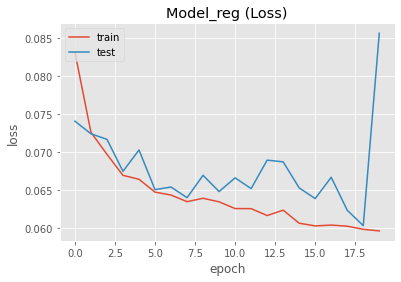

In [28]:
# Gráfica resumen de los datos del entrenamiento para la función loss
# del modelo model_reg
plt.style.use("ggplot")
plt.plot(model_LSTM.history.history['loss'])
plt.plot(model_LSTM.history.history['val_loss'])
plt.title('Model_reg (Loss)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Guardamos el modelo LSTM para su posterior utilización

In [29]:
# Guardado del modelo en formato hdf
model_LSTM.save("C:/PdM/models/model_LSTM_without_anomalies.h5")
print("Modelo guardado")

Modelo guardado


# Comprobación: Validación - Test


Cargamos el conjunto de datos para realizar la validación/test de una forma más visual

Para poder aplicar el modelo, deberemos usar los datos normalizados con las características según la normalización aplicada al conjunto de entrenamiento durante la creación del modelo.

In [30]:
# Declaramos el conjunto de test y test normalizado
conjunto_test = subconj_T
conjunto_test_normalizado = subconj_T_norm

Damos formato a los datos para ser compatibles con el formato de input del modelo LSTM.

In [31]:
def create_dataset_LSTM_test(df, lookback, future, column_features):
    df_feature = df[column_features]

    # Convertimos el dataframe en un numpy array
    numpy_features = df_feature.to_numpy()
    
    # Creación de listas vacías auxiliares
    features_set = [] 
   
    for i in range(lookback, df.shape[0] - future + 1):
        features_set.append(numpy_features[i - lookback:i]) 

        # Redimensionamiento numpy arrays
    features = np.array(features_set)
    features = np.reshape(features, (features.shape[0], features.shape[1], len(column_features) ))
    return features

Cremos el conjunto de test con el formato necesario para que el algoritmo LSTM funcione correctamente.

In [32]:
X_test = create_dataset_LSTM_test(conjunto_test_normalizado, size_window, 0, column_features)

Realizamos la predicción del modelo LSTM sobre los datos de test e invertimos la normalización para obtener los valores del ciclo sin normalizar.

In [33]:
# Predicción modelo LSTM
X_pred_t = model_LSTM.predict(X_test)
# Inversión de la normalización
X_pred_t = scaler_label.inverse_transform(X_pred_t)

Creamos la RUL del conjunto de test con datos sin normalizar

In [34]:
# Creación de la serie con la RUL sin normalizar del conjunto de Test
# para usarla en la comparación con la predicción.

df_t_RUL = pd.DataFrame(conjunto_test["RUL"])
df_t_RUL.reset_index(inplace=True)
df_t_RUL = df_t_RUL["RUL"]

Para poder realizar la comprobación en su ciclo adecuado, eliminaremos los datos pertenecientes a la ventana temporal, ya que no disponemos predicciones sobre estos.

In [35]:
# Conversión de la predicción en objeto lista para poderlo comparar con RUL
prediction = [x[0] for x in X_pred_t]

# Eliminación elementos correspondientes con la ventana temporal
df_t_RUL= list(df_t_RUL[(len(df_t_RUL) - len(prediction)):])


# Comprobación de igualdad de dimensiones de las listas
len(df_t_RUL) == len(prediction)

True

Visualizaremos los datos RUL reales con los predichos por el modelo LSTM

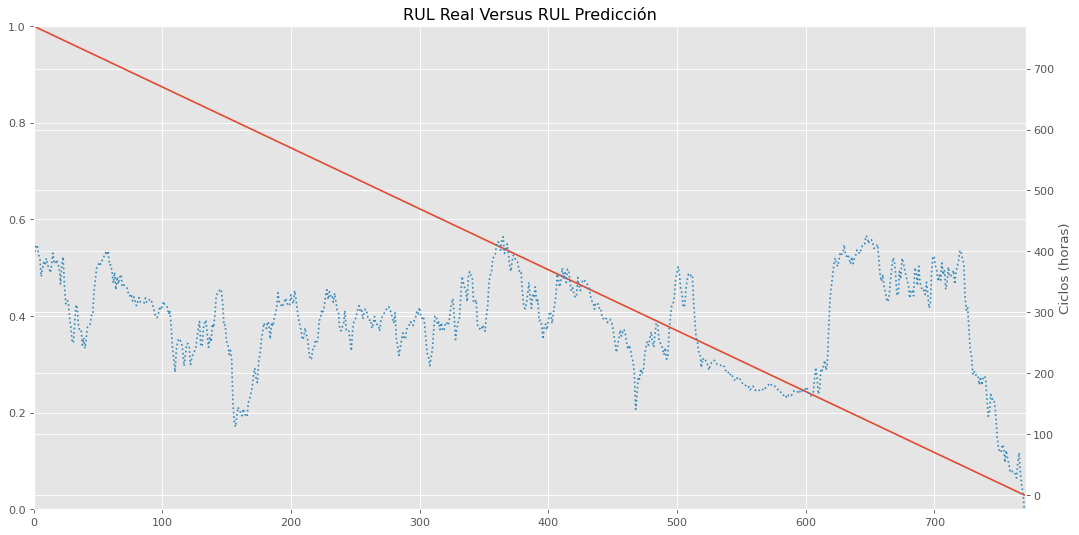

In [36]:
# Visualización

fig, ax = plt.subplots(figsize=(16, 8), dpi=80)

ax.set_xlim(0,len(prediction))

ax2 = ax.twinx()
max_eje = max(max(df_t_RUL), max(prediction))
min_eje = min(min(df_t_RUL), min(prediction))
ax2.set_ylim(min_eje, max_eje)

plt.plot(df_t_RUL, linestyle='solid')
plt.plot(prediction, linestyle='dotted')
plt.title("RUL Real Versus RUL Predicción")
plt.ylabel("Ciclos (horas)")

plt.show()

Comprobamos el último valor predicho, el cual debería ser cero por definición:

In [37]:
# Último valor de la predicción (valor del ciclo donde la máquina falla teóricamente)
print("Desfase en el momento de rotura entre el modelo y la realidad: " + str(prediction[-1]) + " horas")

Desfase en el momento de rotura entre el modelo y la realidad: -23.346708 horas


Para realizar la cuantificación del error obtenido, usaremos el error absoluto medio (MAE), que es una métrica popular que, además de que las unidades de la puntuación de error coinciden con las unidades del valor objetivo que se predice, a diferencia del RMSE, los cambios en MAE son lineales y por lo tanto intuitivos y se ajustan bien a nuestro problema.

In [38]:
# Cálculo de MAE
error = mae(df_t_RUL, prediction)
print(f"El modelo tiene un error MAE de: {round(error,2)} horas")

El modelo tiene un error MAE de: 195.28 horas


Una vez tenemos las predicciones de la regresión, podemos convertirlo en un modelo de clasificación simplemente marcando un umbral y definiendo los campos como normales o no (warning) según la predicción pase el umbral o no.  
  
Creamos unas listas auxiliares a tal efecto y aplicamos la matriz de confusión.

In [39]:
# Definición de umbral
umbral = 240

# Creación de listas auxiliares
actual_RUL = ["Normal"  if x >= umbral else "Warning" for x in df_t_RUL]
prediccion_RUL = ["Normal"  if x >= umbral else "Warning" for x in prediction]

# Definición matriz de confusión
y_actu = pd.Series(actual_RUL, name='Actual')
y_pred = pd.Series(prediccion_RUL, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(f"Para un umbral de {umbral} horas, la matriz de confusion es: ")
df_confusion

Para un umbral de 240 horas, la matriz de confusion es: 


Predicted  Normal  Warning
Actual                    
Normal        452       79
Warning       110      130

Calculamos las métricas típicas de un problema de clasificación:

In [40]:
# Definiendo Verdaderos Positivos (TP) y Negativos (TN); Falsos Positivos (FP) Y Negativos (FN)
TN = df_confusion["Normal"]["Normal"]
FP = df_confusion["Warning"]["Normal"]
FN = df_confusion["Normal"]["Warning"]
TP = df_confusion["Warning"]["Warning"]

In [41]:
# Precisión
precision = TP/(TP + FP)
print(f"El modelo tiene una precisión de {round(precision, 2)}")


# Exactitud (Accuracy)
accuracy = (TP + TN) / (TP + TN + FP +FN)
print(f"El modelo tiene un accuracy de {round(accuracy, 2)}")

# Exhaustividad (recall)
recall = TP/(TP + FN)
print(f"El modelo tiene un recall de {round(recall, 2)}")

# F1 
f1 = 2*((precision*recall)/(precision+recall))
print(f"El modelo tiene un f1 de {round(f1, 2)}")


El modelo tiene una precisión de 0.62
El modelo tiene un accuracy de 0.75
El modelo tiene un recall de 0.54
El modelo tiene un f1 de 0.58
